# Implementing an image compressor

You will need to install the following commands and enable ipywidgets

In [10]:
!pip install scikit-image
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
# start by importing some necessary packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy.linalg as la

We read in a test image and convert to a $[0,1]$ scale before performing any arithmetic.

Image dimensions: (672, 552, 4)


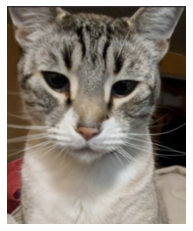

In [6]:
im = imread("./bender.png")
im = im.astype(float)/255.
print("Image dimensions:",im.shape)

plt.imshow(im)
plt.axis('off')
plt.show()

Next, we vertically stack the color channels to form a $3m\times{n}$ image, where the $n$ columns of the image represent our samples, and center the image about its mean to obtain the matrix $A$.

In [7]:
m,n,p = im.shape
S = np.vstack([im[:,:,0],im[:,:,1],im[:,:,2]])

# compute the mean of each row to obtain a mean column.
Sm = np.mean(S, axis=1, keepdims=True)

# compute the centered matrix A.
A = S - Sm



Now create a function to compute the svd of the matrix manually. We will compare this to the `numpy.linalg.svd` method. Just like the `np.linalg.svd` method, return the matrices $U$ and $V^\top$, as well as a 1d array containing the singular values.

With your group, please write a function ```rank_approx(A, k)``` which accepts a centered matrix $A$ and a maximum rank $k$, and assembles a list $L$ of the first $k$ rank-one matrices in the low-rank approximation of the matrix. The list $L$ should be of the form
$$
L = [\sigma_1 u_1 v_1^T, \sigma_2 u_2 v_2^T, ..., \sigma_k u_k v_k^T]
$$
Return the list as your output.

In [9]:
def rank_approx(A, k):
    # your code here
    U,S,V=la.svd(A)
    Uk=U[:,:k]
    Vk=V[:k,:]
    Sk=S[:k]
    L=[]
    for uk,sk,vk in zip(Uk.T,Sk,Vk):
        L.append(sk*np.outer(uk,vk))
    return L 


print(np.shape(A))
L=rank_approx(A,3)


(2016, 552)


The function ```reconstruct(L, r, Sbar)``` below accepts the list of low-rank approximations $L$, a target rank $r < k$, and the column mean $\bar{S}$, and returns the rank-$r$ reconstructed image. If your ```rank_approx``` function is set up correctly, you should be able to run the following cell and plot a test reconstruction:

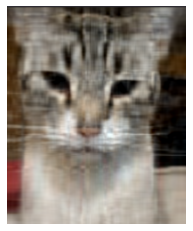

In [10]:
def reconstruct(L, r, Sbar):
    if r >= len(L):
        print("Error: r must be less than the length of L.")
        return

    m = len(Sbar)//3 # the leading dimension of a single channel

    # Reconstruct the original image up to rank r.
    Ar = np.sum(L[:r], axis=0)

    # Add back the mean and reshape into m by n by p.
    Ar += Sbar.reshape(-1,1)
    imr = np.stack([Ar[:m,:],Ar[m:2*m,:],Ar[2*m:,:]], axis=2)

    # truncate values and return the reconstructed image.
    imr[imr<0] = 0; imr[imr>1] = 1
    return imr

# Run a test:
k = 16; r = 12
L = rank_approx(A, k)
imr = reconstruct(L, r, Sm)
plt.imshow(imr)
plt.axis("off")
plt.show()

If the above test was successful, you should now be able to run the following widget to interactively vary the rank and visualize the resulting reconstruction. With your group, decide how many singular vectors you feel are necessary to reconstruct the image before differences between the original become imperceptible.

In [11]:
import ipywidgets as widgets
from ipywidgets import interactive

rmax = min(80,n)
L = rank_approx(A, rmax+1)
rank_slider = widgets.IntSlider(
    value=1, min=1, max=rmax, step=1,
    description='rank:', continuous_update=False)

def rank_slider_plot(r = 1):
    plt.close()
    imr = reconstruct(L, r, Sm)

    # Plot the original and compressed images.
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.imshow(im)
    ax1.set_title("original", size=16)
    ax1.axis("off")

    ax2.imshow(imr)
    ax2.set_title("reconstruction", size=16)
    ax2.axis("off")
    plt.show()

interactive_plot = interactive(rank_slider_plot, r=rank_slider)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=1, continuous_update=False, description='rank:', max=80, min=1), Output(…

## Supplementary Material: Image Compression with PCA
You can also do image compression and reconstruction with PCA. Below you can see how using `scikit-learn`. The cool thing is that you can plot the explained variance and use that to pick a reasonable target value for $k$. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2016, 552)


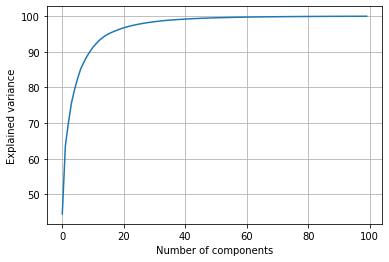

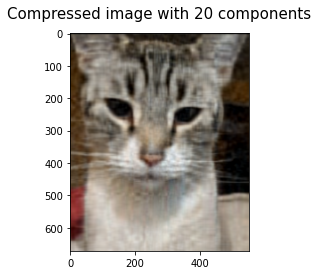

In [163]:
import numpy as np
from sklearn.decomposition import PCA
pca_100=PCA(n_components=100)
pca_100.fit(S)
plt.grid()
plt.plot(np.cumsum(pca_100.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

n_components=20
pca_ = PCA(n_components=n_components)
bender_reduced = pca_.fit_transform(S)
bender_recovered = pca_.inverse_transform(bender_reduced)
print(np.shape(bender_recovered))

plt.figure()
m = len(Sm)//3
Ar_ = bender_recovered 
imr = np.stack([Ar_[:m,:],Ar_[m:2*m,:],Ar_[2*m:,:]], axis=2)
plt.imshow(imr, cmap='gray_r')
plt.title('Compressed image with {} components'.format(n_components), fontsize=15, pad=15)
plt.savefig("image_pca.png")